# IC50 Classification Using Neural Network Models

In [1]:
#https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
import os
import numpy as np
import random as python_random
#from mpl_toolkits.mplot3d import Axes3D
#from sklearn.datasets import make_blobs
from mlxtend.plotting import plot_decision_regions
SEED=1234
np.random.seed(SEED)
python_random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

import tensorflow as tf
import time
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold #Split module from sklearn
import pandas as pd
from pandas import Series
import csv
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import model_selection
from math import log
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import make_scorer
from keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from PIL import Image
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, Dense
from sklearn.manifold import TSNE
import keras
from sklearn.metrics import matthews_corrcoef
##https://github.com/mediumssharma23/avisualintroductiontonn/blob/master/visual_nn.ipynb##

In [2]:
def readdata(filename):
    text = []
    y = []
    with open(filename, encoding='latin1') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            if row and len(row[2]) > 10: 
                text.append(row[2]) 
                y.append(row[7])
    return [text, y]

In [3]:
def preprocessing(text, y):
    tokenizer = Tokenizer(num_words=1024) # The number of Max Words in Document
    tokenizer.fit_on_texts(text) #Word Index

    X = tokenizer.texts_to_sequences(text) 
    print('lengths of 10 documents:', [len(doc) for doc in X[:10]])
    print('num of tokens:', len(tokenizer.word_index))

    maxlen = 212 #The number of Max Words in Document = 212
    X = pad_sequences(X, maxlen=maxlen, truncating='pre') 
    # Labeling
    label_dict = {'Active':0, 'Inactive':1}
    y2 = [label_dict[c] for c in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=10)
    
    print('Train set count:', len(X_train))
    print('Test set count:', len(X_test))
    print('Test samples:', y_test[:20])
    print(X_train.shape, X_test.shape, X.shape)
    return [X_train, X_test, y_train, y_test, X, y2]

In [4]:
def preprocessing_3rd(text, y):
    max_words = 212 #Using Words
    
    tokenizer = Tokenizer(num_words=1024) # The number of Max Words in Document
    tokenizer.fit_on_texts(text) #Word Index

    X = tokenizer.texts_to_sequences(text) 
    print('lengths of 10 documents:', [len(doc) for doc in X[:10]])
    print('num of tokens:', len(tokenizer.word_index))

    maxlen = 212 #The number of Max Words in Document
    X = pad_sequences(X, maxlen=maxlen, truncating='pre') 
    # Labeling
    label_dict = {'Active':0, 'Inactive':1}
    y2 = [label_dict[c] for c in y]

    print('Train set count:', len(X))
    print('Test samples:', y2[:20])
    return [X, y2]

In [5]:
Classifier_input = preprocessing(readdata('dataset.csv')[0],readdata('dataset.csv')[1])
X_train=Classifier_input[0]
X_train = np.array(X_train)
X_train= np.asarray(X_train)
print(X_train)

lengths of 10 documents: [66, 66, 68, 66, 67, 70, 66, 69, 65, 66]
num of tokens: 1024
Train set count: 48220
Test set count: 12055
Test samples: [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
(48220, 212) (12055, 212) (60275, 212)
[[  0   0   0 ...  54  23 562]
 [  0   0   0 ... 306 465 282]
 [  0   0   0 ... 819 309 950]
 ...
 [  0   0   0 ... 599 217 183]
 [  0   0   0 ... 166  26 104]
 [  0   0   0 ...  23 465  93]]


In [6]:
np.random.seed(42)
tf.random.set_seed(42)
def Loc_MLP(dataset,dataset_3rd):
    maxlen = 212
    X_train=dataset[0]
    X_train = np.array(X_train)
    X_test=dataset[1]
    X_test= np.array(X_test)
    y_train=dataset[2]
    y_test=dataset[3]
    X1 = dataset[4]
    y1= dataset[5]
    X = np.array(X1)
    y = np.array(y1)
    X_3rd=dataset_3rd[0]
    y_3rd=dataset_3rd[1]
    y_3rd = np.array(y_3rd)

    model = keras.models.load_model('Embedding.h5')
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    history = model.fit(np.asarray(X_train), np.asarray(y_train), 
                    epochs=15,
                    batch_size=256,
                    validation_split=0.2)
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
        
    y_pred_keras = model.predict(X_test).ravel()

    y_pred_probs = model.predict(X_test)
    y_pred_probs_train = model.predict(X_train)
    y_pred_probs_3rd = model.predict(X_3rd)
    
    # Convert probabilities to class labels based on a threshold
    threshold = 0.5  # Adjust the threshold as needed
    y_pred_classes = (y_pred_probs > threshold).astype(int)
    y_pred_classes_train = (y_pred_probs_train > threshold).astype(int)
    y_pred_classes_3rd = (y_pred_probs_3rd > threshold).astype(int)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    
    auc_keras = auc(fpr_keras, tpr_keras)
    
    # clear the plot
    pyplot.clf()
    
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
   #pyplot.show()
    pyplot.savefig("MLP_LOSS.png",dpi=300) 
    
    #clear the plot
    pyplot.clf()
    
    history_dict = history.history
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    #pyplot.show()
    pyplot.savefig("MLP_ACC.png",dpi=300)
    score = model.evaluate(np.asarray(X_test),np.asarray(y_test))
    score2 = model.evaluate(np.asarray(classifier_3rd[0]),np.asarray(classifier_3rd[1]))
    print(score)
    print(score2)
    
    # clear the plot
    pyplot.clf()
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    ns_probs_2 = [0 for _ in range(len(y_train))]
    ns_probs_3 = [0 for _ in range(len(y_3rd))]
    # predict probabilities
    lr_probs = model.predict(X_test)
    lr_probs_2 = model.predict(X_train)
    lr_probs_3 = model.predict(X_3rd)


    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
  
    ns_fpr_2, ns_tpr_2, _ = roc_curve(y_train, ns_probs_2)
    lr_fpr_2, lr_tpr_2, _ = roc_curve(y_train, lr_probs_2)
    
    ns_fpr_3, ns_tpr_3, _ = roc_curve(y_3rd, ns_probs_3)
    lr_fpr_3, lr_tpr_3, _ = roc_curve(y_3rd, lr_probs_3)
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    
    ns_auc_2 = roc_auc_score(y_train, ns_probs_2)
    lr_auc_2 = roc_auc_score(y_train, lr_probs_2)
    
    ns_auc_3 = roc_auc_score(y_3rd, ns_probs_3)
    lr_auc_3 = roc_auc_score(y_3rd, lr_probs_3)
    
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='MLP_Test, AUC=%.3f' % (lr_auc))
    pyplot.plot(lr_fpr_2, lr_tpr_2, color='green', marker='.', label='MLP_Training, AUC=%.3f' % (lr_auc_2))
    pyplot.plot(lr_fpr_3, lr_tpr_3, color='red', marker='.', label='MLP_3rd, AUC=%.3f' % (lr_auc_3))
    
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    # show the plot
    pyplot.savefig("MLP.png",dpi=300)  
    # summarize scores
    print('MLP_Test: ROC AUC=%.3f' % (lr_auc))
    print('MLP_Training: ROC AUC=%.3f' % (lr_auc_2))
    print('MLP_3rd: ROC AUC=%.3f' % (lr_auc_3))

    # confusion matrix
    matrix = confusion_matrix(y_test,y_pred_classes)
    matrix2= confusion_matrix(y_train, y_pred_classes_train)
    matrix3= confusion_matrix(y_3rd, y_pred_classes_3rd)
    print(matrix)
    print(matrix2)
    print(matrix3)

In [7]:
def Loc_MLP_simp(dataset,dataset_3rd):
    maxlen = 212
    X_train=dataset[0]
    X_test=dataset[1]
    y_train=dataset[2]
    y_test=dataset[3]
    X1 = dataset[4]
    y1 = dataset[5]
    X = np.array(X1)
    y = np.array(y1)
    X_3rd=dataset_3rd[0]
    y_3rd=dataset_3rd[1]

    model = keras.models.load_model('Embedding.h5')
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    model.summary()

    history = model.fit(np.asarray(X_train), np.asarray(y_train), epochs=15, batch_size=256, validation_split=0.2)
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']    
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    pyplot.savefig("MLP_LOSS.png",dpi=300) 
    
    #clear the plot
    pyplot.clf()
    
    history_dict = history.history
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
# show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    pyplot.savefig("MLP_ACC.png",dpi=300)
    score = model.evaluate(np.asarray(X_test),np.asarray(y_test))
    score2 = model.evaluate(np.asarray(classifier_3rd[0]),np.asarray(classifier_3rd[1]))
    print(score)
    print(score2)
    # clear the plot
    pyplot.clf()
    
    # Load your Keras model
    model = keras.models.load_model('Embedding.h5')
    
    activities = model.predict(X_3rd)

    # Determine the classification of the compounds based on their predicted activity
    classifications = np.where(activities > 0.5, "Active", "Inactive")

  
    if np.count_nonzero(classifications == "Active") > np.count_nonzero(classifications == "Inactive"):
        print("The compound is classified as Active.")
    else:
        print("The compound is classified as Inactive.")

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

def Loc_RNN(dataset,dataset_3rd):
    X_train=dataset[0]
    X_test=dataset[1]
    y_train=dataset[2]
    y_test=dataset[3]
    X1 = dataset[4]
    y1= dataset[5]
    X = np.array(X1)
    y = np.array(y1)
    X_3rd=dataset_3rd[0]
    y_3rd=dataset_3rd[1]
    y_3rd = np.array(y_3rd)

    model = keras.models.load_model('RNN.h5')
    model.summary()
    rmsprop = RMSprop(learning_rate=0.001) #Set the Learning Rate

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    model.summary()

    history = model.fit(np.asarray(X_train), np.asarray(y_train), 
                    epochs=15,
                    batch_size=256,
                    validation_split=0.2)
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
        
    y_pred_keras = model.predict(X_test).ravel()
    
    y_pred_classes = model.predict(X_test)
    y_pred_classes= y_pred_classes.flatten()
    y_pred_classes_train = model.predict(X_train)
    y_pred_classes_train= y_pred_classes_train.flatten()
    y_pred_classes_3rd = model.predict(X_3rd)
    y_pred_classes_3rd= y_pred_classes_3rd.flatten()

    # extract the predicted class labels
    y_pred_classes = np.where(y_pred_classes > 0.5, 1, 0)
    y_pred_classes_train = np.where(y_pred_classes_train > 0.5, 1, 0)
    y_pred_classes_3rd = np.where(y_pred_classes_3rd > 0.5, 1, 0)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    
    auc_keras = auc(fpr_keras, tpr_keras)
    
    # clear the plot
    pyplot.clf()
    
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
   #pyplot.show()
    pyplot.savefig("RNN_LOSS.png",dpi=300) 
    
    #clear the plot
    pyplot.clf()
    
    history_dict = history.history
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    #pyplot.show()
    pyplot.savefig("RNN_ACC.png",dpi=300)
    score = model.evaluate(np.asarray(X_test),np.asarray(y_test))
    score2 = model.evaluate(np.asarray(classifier_3rd[0]),np.asarray(classifier_3rd[1]))
    print(score)
    print(score2)
    
    # clear the plot
    pyplot.clf()
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    ns_probs_2 = [0 for _ in range(len(y_train))]
    ns_probs_3 = [0 for _ in range(len(y_3rd))]
    # predict probabilities
    lr_probs = model.predict(X_test)
    lr_probs_2 = model.predict(X_train)
    lr_probs_3 = model.predict(X_3rd)


    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
  
    ns_fpr_2, ns_tpr_2, _ = roc_curve(y_train, ns_probs_2)
    lr_fpr_2, lr_tpr_2, _ = roc_curve(y_train, lr_probs_2)
    
    ns_fpr_3, ns_tpr_3, _ = roc_curve(y_3rd, ns_probs_3)
    lr_fpr_3, lr_tpr_3, _ = roc_curve(y_3rd, lr_probs_3)
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    
    ns_auc_2 = roc_auc_score(y_train, ns_probs_2)
    lr_auc_2 = roc_auc_score(y_train, lr_probs_2)
    
    ns_auc_3 = roc_auc_score(y_3rd, ns_probs_3)
    lr_auc_3 = roc_auc_score(y_3rd, lr_probs_3)
    
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RNN_Test, AUC=%.3f' % (lr_auc))
    pyplot.plot(lr_fpr_2, lr_tpr_2, color='green', marker='.', label='RNN_Training, AUC=%.3f' % (lr_auc_2))
    pyplot.plot(lr_fpr_3, lr_tpr_3, color='red', marker='.', label='RNN_3rd, AUC=%.3f' % (lr_auc_3))
    
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    # show the plot
    pyplot.savefig("RNN.png",dpi=300)  
    # summarize scores
    print('RNN_Test: ROC AUC=%.3f' % (lr_auc))
    print('RNN_Training: ROC AUC=%.3f' % (lr_auc_2))
    print('RNN_3rd: ROC AUC=%.3f' % (lr_auc_3))

    # confusion matrix
    matrix = confusion_matrix(y_test,y_pred_classes)
    matrix2= confusion_matrix(y_train, y_pred_classes_train)
    matrix3= confusion_matrix(y_3rd, y_pred_classes_3rd)
    print(matrix)
    print(matrix2)
    print(matrix3)

In [9]:
def Loc_RNN_simp(dataset,dataset_3rd):
    X_train=dataset[0]
    X_test=dataset[1]
    y_train=dataset[2]
    y_test=dataset[3]
    X1 = dataset[4]
    y1= dataset[5]
    X = np.array(X1)
    y = np.array(y1)
    X_3rd=dataset_3rd[0]
    y_3rd=dataset_3rd[1]    
   
    model = keras.models.load_model('RNN.h5')
    model.summary()
    rmsprop = RMSprop(learning_rate=0.001) #Set the Learning Rate

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    model.summary()

    history = model.fit(np.asarray(X_train), np.asarray(y_train), 
                    epochs=15,
                    batch_size=256,
                    validation_split=0.2)
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
        
    y_pred_keras = model.predict(X_test).ravel()
    y_pred_classes0 = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred_classes0, axis=-1)
    
    y_pred_classes_train0= model.predict(X_train, verbose=0)
    y_pred_classes_train=np.argmax(y_pred_classes_train0, axis=-1)
    
    y_pred_classes_3rd0= model.predict(X_3rd, verbose=0)
    y_pred_classes_3rd = np.argmax(y_pred_classes_3rd0, axis=-1)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    
    auc_keras = auc(fpr_keras, tpr_keras)
    
    # clear the plot
    pyplot.clf()
    
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
   #pyplot.show()
    pyplot.savefig("RNN_LOSS.png",dpi=300) 
    
    # clear the plot
    pyplot.clf()

    history_dict = history.history
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    #pyplot.show()
    pyplot.savefig("RNN_ACC.png",dpi=300)
    score = model.evaluate(np.asarray(X_test),np.asarray( y_test))
    score2 = model.evaluate(np.asarray(classifier_3rd[0]),np.asarray(classifier_3rd[1]))
    print(score)
    print(score2)
    
    # clear the plot
    pyplot.clf()
    # Load your Keras model
    model = keras.models.load_model('RNN.h5')
    
    activities = model.predict(X_3rd)

    # Determine the classification of the compounds based on their predicted activity
    classifications = np.where(activities > 0.5, "Active", "Inactive")

    if np.count_nonzero(classifications == "Active") > np.count_nonzero(classifications == "Inactive"):
        print("The compound is classified as Active.")
    else:
        print("The compound is classified as Inactive.")

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

def Loc_CNN(dataset,dataset_3rd):
    X_train=dataset[0]
    X_train = np.array(X_train)
    X_test=dataset[1]
    X_test= np.array(X_test)
    y_train=dataset[2]
    y_test=dataset[3]
    X1 = dataset[4]
    y1= dataset[5]
    X = np.array(X1)
    y = np.array(y1)
    X_3rd=dataset_3rd[0]
    y_3rd=dataset_3rd[1]
    y_3rd = np.array(y_3rd)

    model = keras.models.load_model('CNN.h5')
    model.summary()
   
    rmsprop = RMSprop(learning_rate=0.001) #Learning Rate

    model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])

    history = model.fit(np.asarray(X_train), np.asarray(y_train), 
                    epochs=15,
                    batch_size=256,
                    validation_split=0.2)
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    y_pred_keras = model.predict(X_test).ravel()

    y_pred_classes = model.predict(X_test)
    y_pred_classes= y_pred_classes.flatten()
    
    y_pred_classes_train = model.predict(X_train)
    y_pred_classes_train= y_pred_classes_train.flatten()
    y_pred_classes_3rd = model.predict(X_3rd)
    y_pred_classes_3rd= y_pred_classes_3rd.flatten()

    # extract the predicted class labels
    y_pred_classes = np.where(y_pred_classes > 0.5, 1, 0)
    y_pred_classes_train = np.where(y_pred_classes_train > 0.5, 1, 0)
    y_pred_classes_3rd = np.where(y_pred_classes_3rd > 0.5, 1, 0)
    
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    
    auc_keras = auc(fpr_keras, tpr_keras)
    
    # clear the plot
    pyplot.clf()
    
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
   #pyplot.show()
    pyplot.savefig("CNN_LOSS.png",dpi=300) 
    
    #clear the plot
    pyplot.clf()
    
    history_dict = history.history
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    #pyplot.show()
    pyplot.savefig("CNN_ACC.png",dpi=300)
    score = model.evaluate(np.asarray(X_test),np.asarray(y_test))
    score2 = model.evaluate(np.asarray(classifier_3rd[0]),np.asarray(classifier_3rd[1]))
    print(score)
    print(score2)
    
    # clear the plot
    pyplot.clf()
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    ns_probs_2 = [0 for _ in range(len(y_train))]
    ns_probs_3 = [0 for _ in range(len(y_3rd))]
    # predict probabilities
    lr_probs = model.predict(X_test)
    lr_probs_2 = model.predict(X_train)
    lr_probs_3 = model.predict(X_3rd)


    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
  
    ns_fpr_2, ns_tpr_2, _ = roc_curve(y_train, ns_probs_2)
    lr_fpr_2, lr_tpr_2, _ = roc_curve(y_train, lr_probs_2)
    
    ns_fpr_3, ns_tpr_3, _ = roc_curve(y_3rd, ns_probs_3)
    lr_fpr_3, lr_tpr_3, _ = roc_curve(y_3rd, lr_probs_3)
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    
    ns_auc_2 = roc_auc_score(y_train, ns_probs_2)
    lr_auc_2 = roc_auc_score(y_train, lr_probs_2)
    
    ns_auc_3 = roc_auc_score(y_3rd, ns_probs_3)
    lr_auc_3 = roc_auc_score(y_3rd, lr_probs_3)
    
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CNN_Test, AUC=%.3f' % (lr_auc))
    pyplot.plot(lr_fpr_2, lr_tpr_2, color='green', marker='.', label='CNN_Training, AUC=%.3f' % (lr_auc_2))
    pyplot.plot(lr_fpr_3, lr_tpr_3, color='red', marker='.', label='CNN_3rd, AUC=%.3f' % (lr_auc_3))
    
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    # show the plot
    pyplot.savefig("CNN.png",dpi=300)  
    # summarize scores
    print('CNN_Test: ROC AUC=%.3f' % (lr_auc))
    print('CNN_Training: ROC AUC=%.3f' % (lr_auc_2))
    print('CNN_3rd: ROC AUC=%.3f' % (lr_auc_3))

    # confusion matrix
    matrix = confusion_matrix(y_test,y_pred_classes)
    matrix2= confusion_matrix(y_train, y_pred_classes_train)
    matrix3= confusion_matrix(y_3rd, y_pred_classes_3rd)
    print(matrix)
    print(matrix2)
    print(matrix3)

In [11]:
def Loc_CNN_simp(dataset,dataset_3rd):
    maxlen = 212
    X_train=dataset[0]
    X_test=dataset[1]
    y_train=dataset[2]
    y_test=dataset[3]
    X1 = dataset[4]
    y1 = dataset[5]
    X = np.array(X1)
    y = np.array(y1)
    
    X_3rd=dataset_3rd[0]
    y_3rd=dataset_3rd[1]
    
    model = keras.models.load_model('CNN.h5')
    model.summary()
   
    rmsprop = RMSprop(learning_rate=0.001) #Learning Rate

    model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])

    history = model.fit(np.asarray(X_train), np.asarray(y_train), 
                    epochs=15,
                    batch_size=256,
                    validation_split=0.2)
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
        
    y_pred_keras = model.predict(X_test).ravel()
    y_pred_classes0 = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred_classes0, axis=-1)
    
    y_pred_classes_train0= model.predict(X_train, verbose=0)
    y_pred_classes_train=np.argmax(y_pred_classes_train0, axis=-1)
    
    y_pred_classes_3rd0= model.predict(X_3rd, verbose=0)
    y_pred_classes_3rd=np.argmax(y_pred_classes_3rd0, axis=-1)
    
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    
    auc_keras = auc(fpr_keras, tpr_keras)
    
    # clear the plot
    pyplot.clf()
    
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    #pyplot.show()
    pyplot.savefig("CNN_LOSS.png",dpi=300)
    
    # clear the plot
    pyplot.clf()
    
    history_dict = history.history
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    # show the legend
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    #pyplot.show()
    pyplot.savefig("CNN_ACC.png",dpi=300)
  
    score = model.evaluate(np.asarray(X_test),np.asarray(y_test))
    score2 = model.evaluate(np.asarray(classifier_3rd[0]),np.asarray(classifier_3rd[1]))
    print(score)
    print(score2)
    # clear the plot
    pyplot.clf()

    # Load your Keras model
    model = keras.models.load_model('CNN.h5')
    
    activities = model.predict(X_3rd)

    # Determine the classification of the compounds based on their predicted activity
    classifications = np.where(activities > 0.5, "Active", "Inactive")

    if np.count_nonzero(classifications == "Active") > np.count_nonzero(classifications == "Inactive"):
        print("The compound is classified as Active.")
    else:
        print("The compound is classified as Inactive.")

In [12]:
Classifier_input = preprocessing(readdata('dataset.csv')[0],readdata('dataset.csv')[1])
classifier_3rd = preprocessing_3rd(readdata('lignan.csv')[0],readdata('lignan.csv')[1])

lengths of 10 documents: [66, 66, 68, 66, 67, 70, 66, 69, 65, 66]
num of tokens: 1024
Train set count: 48220
Test set count: 12055
Test samples: [1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
(48220, 212) (12055, 212) (60275, 212)
lengths of 10 documents: [37, 37, 36, 36, 37, 36, 37, 36, 37, 37]
num of tokens: 595
Train set count: 200
Test samples: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
Loc_MLP_simp(Classifier_input,classifier_3rd)

Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_177 (Embedding)   (None, 212, 32)           32768     
                                                                 
 flatten_177 (Flatten)       (None, 6784)              0         
                                                                 
 dense_177 (Dense)           (None, 1)                 6785      
                                                                 
Total params: 39,553
Trainable params: 39,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 2s 11ms/step - loss: 0.2868 - acc: 0.8842 - val_loss: 0.1992 - val_acc: 0.9172
Epoch 2/15
151/151 [==============================] - 1s 9ms/step - loss: 0.1456 - acc: 0.9424 - val_loss: 0.1426 - val_acc: 0.9420
Epoch 3/15
151/151 [===========================

<Figure size 640x480 with 0 Axes>

In [14]:
Loc_CNN_simp(Classifier_input,classifier_3rd)

Model: "sequential_527"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_527 (Embedding)   (None, None, 212)         217088    
                                                                 
 global_max_pooling1d_160 (G  (None, 212)              0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_687 (Dense)           (None, 5)                 1065      
                                                                 
 dense_688 (Dense)           (None, 1)                 6         
                                                                 
Total params: 218,159
Trainable params: 218,159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 11s 71ms/step - loss: 0.3698 - acc: 0.8642 - val_loss: 0.2

<Figure size 640x480 with 0 Axes>

In [15]:
Loc_RNN_simp(Classifier_input,classifier_3rd)

Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)             (None, 32)                8320      
                                                                 
 dense_365 (Dense)           (None, 1)                 33        
                                                                 
Total params: 41,121
Trainable params: 41,121
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)        

<Figure size 640x480 with 0 Axes>

In [16]:
classifier_3rd = preprocessing_3rd(readdata('Steroid.csv')[0],readdata('Steroid.csv')[1])

lengths of 10 documents: [66]
num of tokens: 66
Train set count: 1
Test samples: [0]


In [17]:
Loc_MLP_simp(Classifier_input,classifier_3rd)

Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_177 (Embedding)   (None, 212, 32)           32768     
                                                                 
 flatten_177 (Flatten)       (None, 6784)              0         
                                                                 
 dense_177 (Dense)           (None, 1)                 6785      
                                                                 
Total params: 39,553
Trainable params: 39,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 2s 10ms/step - loss: 0.2868 - acc: 0.8842 - val_loss: 0.1992 - val_acc: 0.9172
Epoch 2/15
151/151 [==============================] - 1s 10ms/step - loss: 0.1456 - acc: 0.9424 - val_loss: 0.1426 - val_acc: 0.9420
Epoch 3/15
151/151 [==========================

<Figure size 640x480 with 0 Axes>

In [18]:
Loc_CNN_simp(Classifier_input,classifier_3rd)

Model: "sequential_527"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_527 (Embedding)   (None, None, 212)         217088    
                                                                 
 global_max_pooling1d_160 (G  (None, 212)              0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_687 (Dense)           (None, 5)                 1065      
                                                                 
 dense_688 (Dense)           (None, 1)                 6         
                                                                 
Total params: 218,159
Trainable params: 218,159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 11s 68ms/step - loss: 0.3698 - acc: 0.8642 - val_loss: 0.2

<Figure size 640x480 with 0 Axes>

In [19]:
Loc_RNN_simp(Classifier_input,classifier_3rd)

Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)             (None, 32)                8320      
                                                                 
 dense_365 (Dense)           (None, 1)                 33        
                                                                 
Total params: 41,121
Trainable params: 41,121
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)        

<Figure size 640x480 with 0 Axes>

In [20]:
classifier_3rd = preprocessing_3rd(readdata('phenylpropanoid.csv')[0],readdata('phenylpropanoid.csv')[1])

lengths of 10 documents: [52, 51, 51, 53, 52, 52, 52, 53, 52, 55]
num of tokens: 614
Train set count: 130
Test samples: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [21]:
Loc_MLP_simp(Classifier_input,classifier_3rd)

Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_177 (Embedding)   (None, 212, 32)           32768     
                                                                 
 flatten_177 (Flatten)       (None, 6784)              0         
                                                                 
 dense_177 (Dense)           (None, 1)                 6785      
                                                                 
Total params: 39,553
Trainable params: 39,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 2s 13ms/step - loss: 0.2868 - acc: 0.8842 - val_loss: 0.1992 - val_acc: 0.9172
Epoch 2/15
151/151 [==============================] - 1s 10ms/step - loss: 0.1456 - acc: 0.9424 - val_loss: 0.1426 - val_acc: 0.9420
Epoch 3/15
151/151 [==========================

<Figure size 640x480 with 0 Axes>

In [22]:
Loc_CNN_simp(Classifier_input,classifier_3rd)

Model: "sequential_527"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_527 (Embedding)   (None, None, 212)         217088    
                                                                 
 global_max_pooling1d_160 (G  (None, 212)              0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_687 (Dense)           (None, 5)                 1065      
                                                                 
 dense_688 (Dense)           (None, 1)                 6         
                                                                 
Total params: 218,159
Trainable params: 218,159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 11s 69ms/step - loss: 0.3698 - acc: 0.8642 - val_loss: 0.2

<Figure size 640x480 with 0 Axes>

In [23]:
Loc_RNN_simp(Classifier_input,classifier_3rd)

Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)             (None, 32)                8320      
                                                                 
 dense_365 (Dense)           (None, 1)                 33        
                                                                 
Total params: 41,121
Trainable params: 41,121
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)        

<Figure size 640x480 with 0 Axes>

In [24]:
classifier_3rd = preprocessing_3rd(readdata('Iridoid.csv')[0],readdata('Iridoid.csv')[1])

lengths of 10 documents: [32, 33, 31, 33, 32]
num of tokens: 67
Train set count: 5
Test samples: [0, 0, 0, 0, 0]


In [25]:
Loc_MLP_simp(Classifier_input,classifier_3rd)

Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_177 (Embedding)   (None, 212, 32)           32768     
                                                                 
 flatten_177 (Flatten)       (None, 6784)              0         
                                                                 
 dense_177 (Dense)           (None, 1)                 6785      
                                                                 
Total params: 39,553
Trainable params: 39,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 2s 11ms/step - loss: 0.2868 - acc: 0.8842 - val_loss: 0.1992 - val_acc: 0.9172
Epoch 2/15
151/151 [==============================] - 1s 10ms/step - loss: 0.1456 - acc: 0.9424 - val_loss: 0.1426 - val_acc: 0.9420
Epoch 3/15
151/151 [==========================

<Figure size 640x480 with 0 Axes>

In [26]:
Loc_CNN_simp(Classifier_input,classifier_3rd)

Model: "sequential_527"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_527 (Embedding)   (None, None, 212)         217088    
                                                                 
 global_max_pooling1d_160 (G  (None, 212)              0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_687 (Dense)           (None, 5)                 1065      
                                                                 
 dense_688 (Dense)           (None, 1)                 6         
                                                                 
Total params: 218,159
Trainable params: 218,159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 11s 70ms/step - loss: 0.3698 - acc: 0.8642 - val_loss: 0.2

<Figure size 640x480 with 0 Axes>

In [27]:
Loc_RNN_simp(Classifier_input,classifier_3rd)

Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)             (None, 32)                8320      
                                                                 
 dense_365 (Dense)           (None, 1)                 33        
                                                                 
Total params: 41,121
Trainable params: 41,121
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)        

<Figure size 640x480 with 0 Axes>

In [28]:
classifier_3rd = preprocessing_3rd(readdata('Saponins.csv')[0],readdata('Saponins.csv')[1])

lengths of 10 documents: [133, 139, 133, 135, 137, 133, 138, 134, 137, 131]
num of tokens: 1012
Train set count: 275
Test samples: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Model: "sequential_527"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_527 (Embedding)   (None, None, 212)         217088    
                                                                 
 global_max_pooling1d_160 (G  (None, 212)              0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_687 (Dense)           (None, 5)                 1065      
                                                                 
 dense_688 (Dense)           (None, 1)                 6         
                                                                 
Total params: 218,159
Trainable params: 218,159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 11s 66ms/step - loss: 0.3698 - acc: 0.8642 - val_loss: 0.2

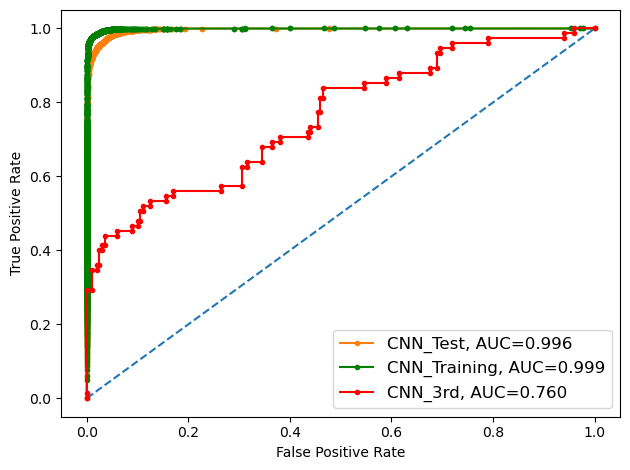

In [29]:
Loc_CNN(Classifier_input,classifier_3rd)

Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_177 (Embedding)   (None, 212, 32)           32768     
                                                                 
 flatten_177 (Flatten)       (None, 6784)              0         
                                                                 
 dense_177 (Dense)           (None, 1)                 6785      
                                                                 
Total params: 39,553
Trainable params: 39,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 2s 11ms/step - loss: 0.2868 - acc: 0.8842 - val_loss: 0.1992 - val_acc: 0.9172
Epoch 2/15
151/151 [==============================] - 2s 11ms/step - loss: 0.1456 - acc: 0.9424 - val_loss: 0.1426 - val_acc: 0.9420
Epoch 3/15
151/151 [==========================

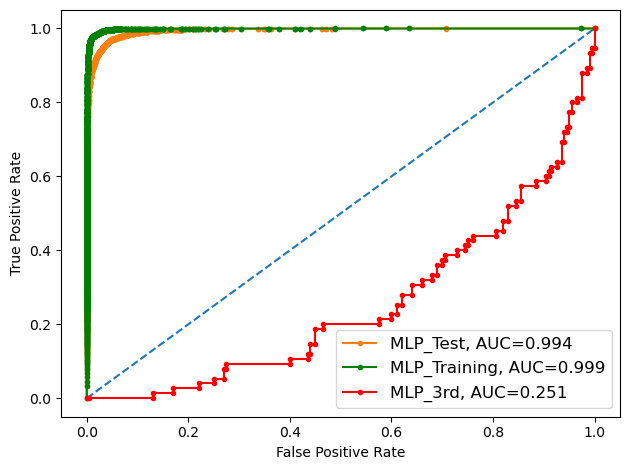

In [30]:
Loc_MLP(Classifier_input,classifier_3rd)

Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)             (None, 32)                8320      
                                                                 
 dense_365 (Dense)           (None, 1)                 33        
                                                                 
Total params: 41,121
Trainable params: 41,121
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)        

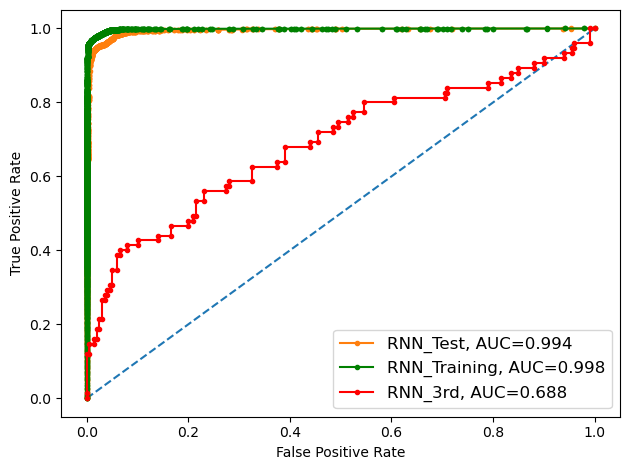

In [31]:
Loc_RNN(Classifier_input,classifier_3rd)

In [32]:
classifier_3rd = preprocessing_3rd(readdata('Flavonoid.csv')[0],readdata('Flavonoid.csv')[1])

lengths of 10 documents: [41, 43, 42, 42, 67, 67, 68, 68, 69, 69]
num of tokens: 1024
Train set count: 484
Test samples: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_177 (Embedding)   (None, 212, 32)           32768     
                                                                 
 flatten_177 (Flatten)       (None, 6784)              0         
                                                                 
 dense_177 (Dense)           (None, 1)                 6785      
                                                                 
Total params: 39,553
Trainable params: 39,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 2s 13ms/step - loss: 0.2868 - acc: 0.8842 - val_loss: 0.1992 - val_acc: 0.9172
Epoch 2/15
151/151 [==============================] - 2s 11ms/step - loss: 0.1456 - acc: 0.9424 - val_loss: 0.1426 - val_acc: 0.9420
Epoch 3/15
151/151 [==========================

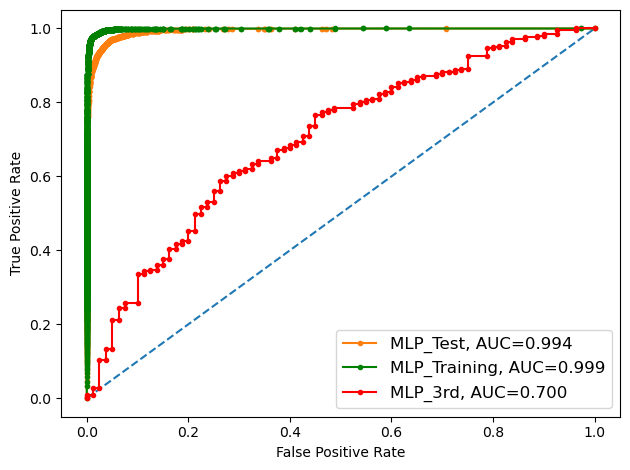

In [33]:
Loc_MLP(Classifier_input,classifier_3rd)

Model: "sequential_527"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_527 (Embedding)   (None, None, 212)         217088    
                                                                 
 global_max_pooling1d_160 (G  (None, 212)              0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_687 (Dense)           (None, 5)                 1065      
                                                                 
 dense_688 (Dense)           (None, 1)                 6         
                                                                 
Total params: 218,159
Trainable params: 218,159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 12s 78ms/step - loss: 0.3698 - acc: 0.8642 - val_loss: 0.2

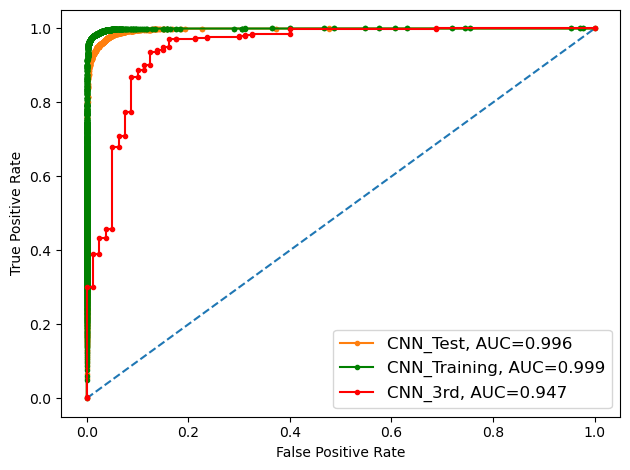

In [34]:
Loc_CNN(Classifier_input,classifier_3rd)

Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)             (None, 32)                8320      
                                                                 
 dense_365 (Dense)           (None, 1)                 33        
                                                                 
Total params: 41,121
Trainable params: 41,121
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)        

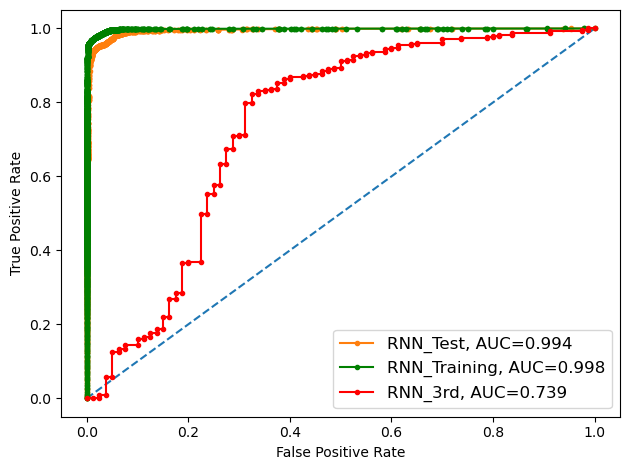

In [35]:
Loc_RNN(Classifier_input,classifier_3rd)

In [36]:
classifier_3rd = preprocessing_3rd(readdata('Coumarin.csv')[0],readdata('Coumarin.csv')[1])

lengths of 10 documents: [58, 55, 62, 59, 60, 58, 62, 59, 58, 62]
num of tokens: 1024
Train set count: 1074
Test samples: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_177 (Embedding)   (None, 212, 32)           32768     
                                                                 
 flatten_177 (Flatten)       (None, 6784)              0         
                                                                 
 dense_177 (Dense)           (None, 1)                 6785      
                                                                 
Total params: 39,553
Trainable params: 39,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 2s 11ms/step - loss: 0.2868 - acc: 0.8842 - val_loss: 0.1992 - val_acc: 0.9172
Epoch 2/15
151/151 [==============================] - 2s 11ms/step - loss: 0.1456 - acc: 0.9424 - val_loss: 0.1426 - val_acc: 0.9420
Epoch 3/15
151/151 [==========================

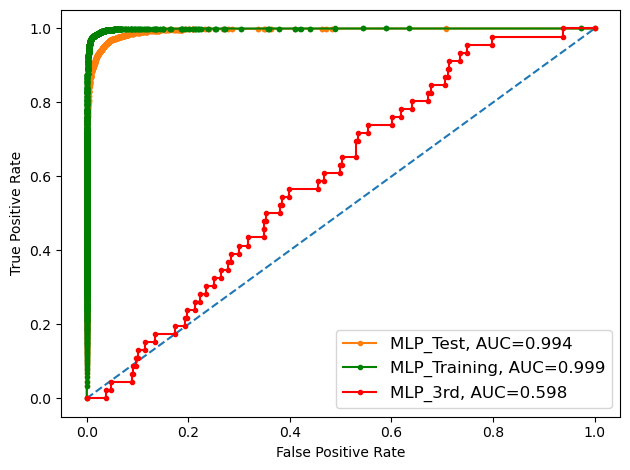

In [37]:
Loc_MLP(Classifier_input,classifier_3rd)

Model: "sequential_527"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_527 (Embedding)   (None, None, 212)         217088    
                                                                 
 global_max_pooling1d_160 (G  (None, 212)              0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_687 (Dense)           (None, 5)                 1065      
                                                                 
 dense_688 (Dense)           (None, 1)                 6         
                                                                 
Total params: 218,159
Trainable params: 218,159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
151/151 [==============================] - 12s 74ms/step - loss: 0.3698 - acc: 0.8642 - val_loss: 0.2

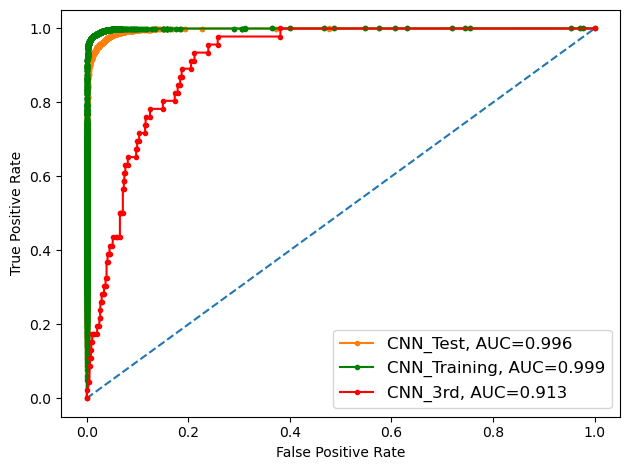

In [38]:
Loc_CNN(Classifier_input,classifier_3rd)

Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)             (None, 32)                8320      
                                                                 
 dense_365 (Dense)           (None, 1)                 33        
                                                                 
Total params: 41,121
Trainable params: 41,121
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_365 (Embedding)   (None, 212, 32)           32768     
                                                                 
 lstm_187 (LSTM)        

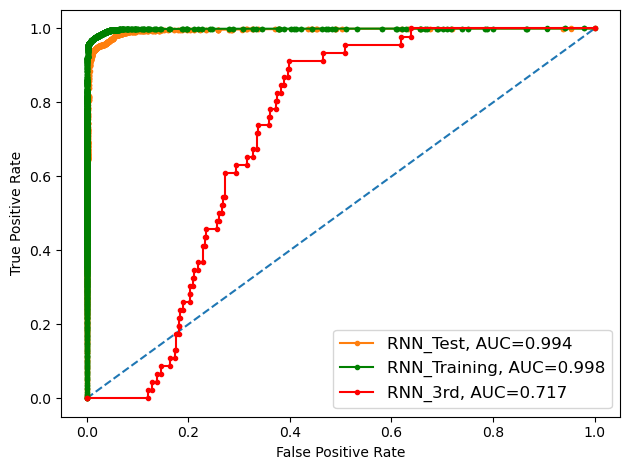

In [39]:
Loc_RNN(Classifier_input,classifier_3rd)

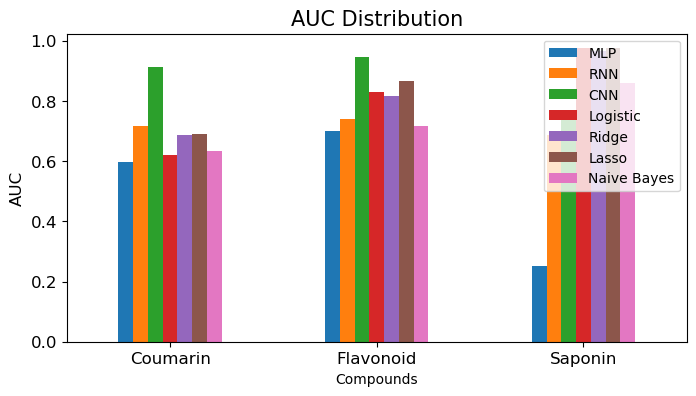

In [41]:
# Make a data definition
_data=[["Coumarin",0.598, 0.717, 0.913, 0.620, 0.687, 0.691, 0.633],["Flavonoid",0.700,0.739, 0.947, 0.829, 0.817, 0.867, 0.718],["Saponin",0.251, 0.688, 0.760, 0.975, 0.967, 0.975, 0.861]]

# Plot multiple columns bar chart
_df = pd.DataFrame(_data, columns=["Compounds", 'MLP', 'RNN', 'CNN', 'Logistic', 'Ridge','Lasso', 'Naive Bayes'], )
_df.plot(x="Compounds", y=['MLP', 'RNN', 'CNN','Logistic', 'Ridge','Lasso', 'Naive Bayes'], kind="bar",rot=0,figsize=(8,4), fontsize=12)
plt.ylabel("AUC",fontsize=12)
plt.title('AUC Distribution', fontsize=15)

# Display the plot
plt.savefig('AUC score based on compounds.jpg', dpi=600, transparent=False, bbox_inches='tight')
plt.show()